# 📊 Projet de segmentation clients par RFM et KMeans

## 🎯 Objectif
Segmenter les clients en groupes homogènes à partir de leurs comportements d'achat en utilisant l'analyse RFM (Recency, Frequency, Monetary) et le clustering KMeans.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


## 📥 Chargement des données

In [3]:
# Charger les données
df = pd.read_excel("KPMG_dummy_data.xlsx", engine="openpyxl")
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


## 🧹 Préparation des données

In [4]:
# Conversion de la date
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Garder uniquement les transactions approuvées  afin de travailler uniquement sur les achats confirmés, ce qui rend l’analyse RFM fiable et exploitable pour le marketing
df = df[df['order_status'] == 'Approved']

# Vérifier les valeurs manquantes
df.isnull().sum()

transaction_id               0
product_id                   0
customer_id                  0
transaction_date             0
online_order               354
order_status                 0
brand                      196
product_line               196
product_class              196
product_size               196
list_price                   0
standard_cost              196
product_first_sold_date    196
dtype: int64

## 📊 Calcul des indicateurs RFM

In [5]:
# Dernière date dans le dataset
last_date = df['transaction_date'].max()

# Calcul RFM
rfm = df.groupby('customer_id').agg({
    'transaction_date': lambda x: (last_date - x.max()).days,
    'transaction_id': 'count',
    'list_price': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,1,7,11,9084.45
1,2,128,3,4149.07
2,3,102,8,9888.23
3,4,195,2,1047.72
4,5,16,6,5903.20


## ⚙️ Standardisation des données

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


## 📌 Choix du nombre de clusters (méthode du coude)

k = 2 | Silhouette Score = 0.3740
k = 3 | Silhouette Score = 0.3780
k = 4 | Silhouette Score = 0.3256
k = 5 | Silhouette Score = 0.3328
k = 6 | Silhouette Score = 0.3082
k = 7 | Silhouette Score = 0.2944
k = 8 | Silhouette Score = 0.2925
k = 9 | Silhouette Score = 0.2732


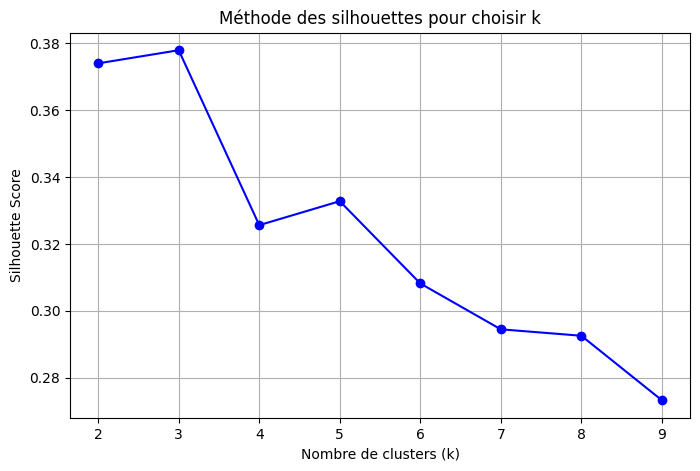


👉 Le meilleur nombre de clusters selon la méthode des silhouettes est : k = 3


In [7]:
silhouette_scores = []
K = range(2, 10)  # On teste entre 2 et 9 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f'k = {k} | Silhouette Score = {score:.4f}')

#  Visualisation du score
plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Méthode des silhouettes pour choisir k")
plt.grid(True)
plt.show()

#  Identifier le meilleur k
best_k = K[np.argmax(silhouette_scores)]
print(f"\n👉 Le meilleur nombre de clusters selon la méthode des silhouettes est : k = {best_k}")

## 🧠 Clustering avec KMeans

In [8]:
# KMeans avec 3 clusters (à adapter selon le coude)
kmeans = KMeans(n_clusters=3, random_state=0)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster
0,1,7,11,9084.45,1
1,2,128,3,4149.07,0
2,3,102,8,9888.23,1
3,4,195,2,1047.72,0
4,5,16,6,5903.20,2


In [9]:
# Exemple basique (à adapter à tes résultats réels)
def assign_profile(cluster):
    if cluster == 2:
        return "Clients premium"
    elif cluster == 1:
        return "Clients réguliers"
    elif cluster == 3:
        return "Clients moyens"
    else:
        return "Clients perdus"

rfm['Profil'] = rfm['Cluster'].apply(assign_profile)

In [10]:
rfm

,CustomerID,Recency,Frequency,Monetary,Cluster,Profil
0,1,7,11,9084.45,1,Clients réguliers
1,2,128,3,4149.07,0,Clients perdus
2,3,102,8,9888.23,1,Clients réguliers
3,4,195,2,1047.72,0,Clients perdus
4,5,16,6,5903.20,2,Clients premium
...,...,...,...,...,...,...
3488,3497,52,3,3744.07,2,Clients premium
3489,3498,127,6,5177.06,0,Clients perdus
3490,3499,51,7,7673.48,1,Clients réguliers
3491,3500,144,6,4922.41,0,Clients perdus


## 📉 Visualisation des clusters avec ACP

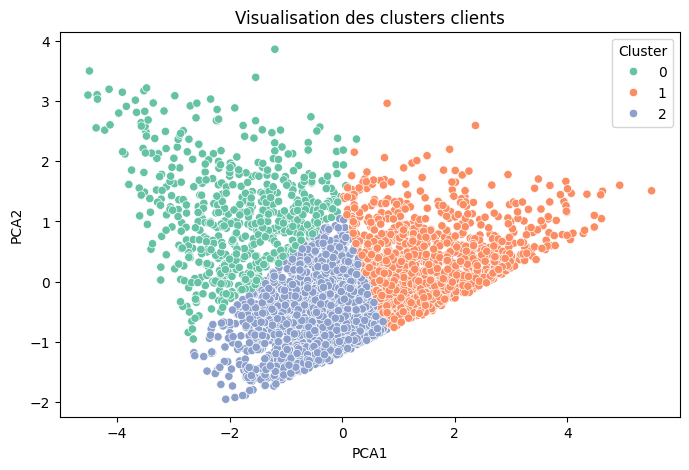

In [11]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

rfm['PCA1'] = X_pca[:, 0]
rfm['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(8, 5))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title("Visualisation des clusters clients")
plt.show()

## 📈 Analyse des groupes de clients

In [12]:
rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(1)

,Recency,Frequency,Monetary
Cluster,,,
0,163.0,3.6,3895.3
1,39.4,8.1,9430.6
2,41.6,4.7,4868.3


# Modèle de Score d’Appétence (Propensity Score): qui Prédire la probabilité qu’un client achète un produit donné à partir de ses données (ex : RFM, fréquence).

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

## 🔹 Étape 1 : Simulation ou importation des données (modifie selon ton cas)
## df = ton dataframe client existant (doit contenir une variable cible)
## Exemple de colonnes : ['frequence', 'montant', 'recence', 'anciennete', 'panier_moyen', 'a_acheté', ect..]

In [14]:
# 🔸 Création d'une variable cible fictive si elle n'existe pas
if 'a_acheté' not in rfm.columns:
    import numpy as np
    rfm['a_acheté'] = np.where(rfm['Monetary'] > rfm['Monetary'].median(), 1, 0)

In [15]:
rfm

,CustomerID,Recency,Frequency,Monetary,Cluster,Profil,PCA1,PCA2,a_acheté
0,1,7,11,9084.45,1,Clients réguliers,2.490826,0.046455,1
1,2,128,3,4149.07,0,Clients perdus,-1.690614,0.515331,0
2,3,102,8,9888.23,1,Clients réguliers,1.146083,1.298112,1
3,4,195,2,1047.72,0,Clients perdus,-3.121538,1.109935,0
4,5,16,6,5903.20,2,Clients premium,0.330291,-0.716823,0
...,...,...,...,...,...,...,...,...,...
3488,3497,52,3,3744.07,2,Clients premium,-1.238011,-0.722622,0
3489,3498,127,6,5177.06,0,Clients perdus,-0.616776,0.943772,0
3490,3499,51,7,7673.48,1,Clients réguliers,0.746842,0.140233,1
3491,3500,144,6,4922.41,0,Clients perdus,-0.792960,1.182044,0


In [16]:
rfm.a_acheté.value_counts()

a_acheté
0    1747
1    1746
Name: count, dtype: int64

In [17]:
# 🔹 Sélection des features disponibles
features = ['Recency', 'Frequency', 'Monetary'] 
X = rfm[features]
y = rfm['a_acheté']

In [18]:
# 🔹 Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [19]:
# 🔹 Modèle
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [20]:
# 🔹 Score d’appétence
rfm['score_appetence'] = model.predict_proba(X)[:, 1]

In [21]:
# 🔹 Évaluation du modèle
print(classification_report(y_test, model.predict(X_test)))
print("AUC score :", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       437
           1       1.00      1.00      1.00       437

    accuracy                           1.00       874
   macro avg       1.00      1.00      1.00       874
weighted avg       1.00      1.00      1.00       874

AUC score : 1.0


🧠 Imagine un élève qui triche à un examen…
Ton modèle, c’est comme un élève.

Tu lui donnes un exercice (les données) et une réponse codée dedans (Montant > médiane → a_acheté = 1).

L’élève regarde la réponse dans l’énoncé, il ne fait aucun effort de compréhension.

Résultat : 20/20 au test… mais échec total à l'examen suivant.

👉 Ça, c’est l’overfitting : le modèle apprend par cœur au lieu de comprendre.

Overfitting (Surapprentissage) : le modèle apprend trop bien les données d’entraînement, y compris les bruits ou détails inutiles.
Conséquence :
Il fonctionne parfaitement sur les données d’apprentissage mais échoue sur de nouvelles données (non vues).

Exemple :
Un élève apprend toutes les réponses par cœur pour un QCM précis, mais échoue s’il reçoit des questions légèrement différentes.

Et c'est le cas de mon modèle

💡 Pourquoi c’est un problème si la variable est trop liée à la cible ?
Quand une feature (comme Montant) est trop corrélée à la cible (par exemple, tu dis que a_acheté = montant > mediane), alors :

Le modèle n'apprend pas vraiment à généraliser.

Il devine la cible directement à partir de la feature (comme une formule mathématique).

Résultat : il donne des performances parfaites sur l'entraînement, mais échoue sur de nouvelles données.



🧠 Ce qu’il faut faire
Soit retirer Montant de tes features,

Soit créer une cible plus réaliste, par exemple :

python
Copier
Modifier
np.random.seed(42)
df['a_acheté'] = np.random.binomial(1, p=0.3, size=len(df))
Soit utiliser des données historiques réelles (ex. : a_acheté basé sur une vraie campagne email, clic, achat, etc.)

 solutions pour corriger l’overfitting :

In [22]:
# ici on enlève la variable monétaire pour éviter l'overfitting cas le montant est très corrélé avec la cible
features = ['Recency', 'Frequency']  # On enlève 'Montant'
X = rfm[features]
y = rfm['a_acheté']  # La cible (à garder)

In [23]:
# crée une variable ciblé pas liée avcec la variable montant
np.random.seed(42)
rfm['a_acheté'] = np.random.binomial(1, p=0.3, size=len(rfm))

In [24]:
rfm

,CustomerID,Recency,Frequency,Monetary,Cluster,Profil,PCA1,PCA2,a_acheté,score_appetence
0,1,7,11,9084.45,1,Clients réguliers,2.490826,0.046455,0,1.00
1,2,128,3,4149.07,0,Clients perdus,-1.690614,0.515331,1,0.00
2,3,102,8,9888.23,1,Clients réguliers,1.146083,1.298112,1,0.99
3,4,195,2,1047.72,0,Clients perdus,-3.121538,1.109935,0,0.00
4,5,16,6,5903.20,2,Clients premium,0.330291,-0.716823,0,0.00
...,...,...,...,...,...,...,...,...,...,...
3488,3497,52,3,3744.07,2,Clients premium,-1.238011,-0.722622,0,0.00
3489,3498,127,6,5177.06,0,Clients perdus,-0.616776,0.943772,0,0.00
3490,3499,51,7,7673.48,1,Clients réguliers,0.746842,0.140233,0,1.00
3491,3500,144,6,4922.41,0,Clients perdus,-0.792960,1.182044,0,0.00


In [25]:
# Étape 2 : Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [35]:
# Étape 3 : Entraîner le modèle
model2 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model2.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [36]:
# Étape 4 : Évaluer
y_train_pred = model2.predict_proba(X_train)[:, 1]
y_test_pred = model2.predict_proba(X_test)[:, 1]
print("AUC Train :", roc_auc_score(y_train, y_train_pred))
print("AUC Test  :", roc_auc_score(y_test, y_test_pred))

AUC Train : 0.9349673871732695
AUC Test  : 0.9216052620077793


🎯 Que signifie ce résultat ?
Ce sont d'excellents scores 🔥 — et la différence est faible entre l'entraînement et le test.

✨ Donc :
Ton modèle généralise bien

Il ne souffre pas d’overfitting important

Il est fiable sur de nouvelles données

🧠 Est-ce qu’il y a surapprentissage (overfitting) ici ?
Non.
Le surapprentissage se remarque quand :

AUC train est très haut (ex : 0.99)

AUC test est bien plus bas (ex : 0.70)

Or ici, l’écart est très faible :
0.935 - 0.921 = 0.014 → très acceptable



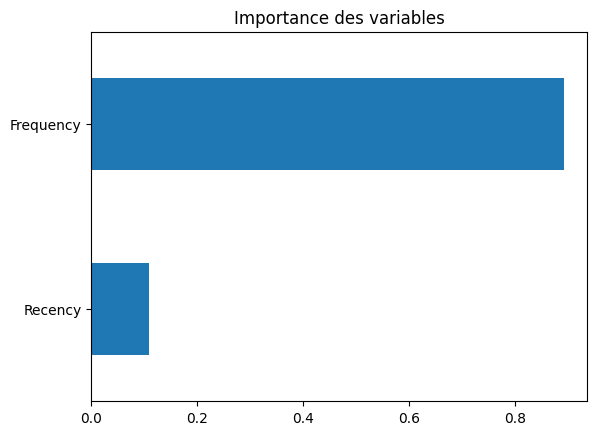

In [37]:
#  Regarder les features importantes :

importances = model2.feature_importances_
pd.Series(importances, index=X_train.columns).sort_values().plot(kind='barh')
plt.title("Importance des variables")
plt.show()


In [38]:
# 🔹 Étape 5 : Prédiction des scores d'appétence
rfm['score_appetence'] = model2.predict_proba(X)[:, 1]



In [39]:
# 🔹 Étape 6 : Analyse des scores
print(classification_report(y_test, model2.predict(X_test)))
print("AUC score :", roc_auc_score(y_test, model2.predict_proba(X_test)[:, 1]))


              precision    recall  f1-score   support

           0       0.84      0.84      0.84       526
           1       0.84      0.84      0.84       522

    accuracy                           0.84      1048
   macro avg       0.84      0.84      0.84      1048
weighted avg       0.84      0.84      0.84      1048

AUC score : 0.9216052620077793


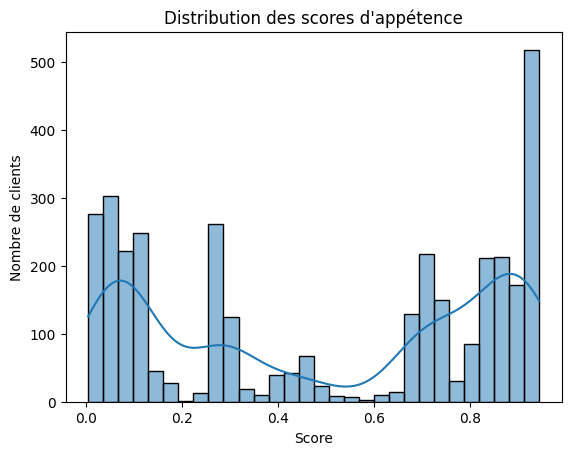

In [32]:

# 🔹 Étape 7 : Visualisation
sns.histplot(rfm['score_appetence'], bins=30, kde=True)
plt.title("Distribution des scores d'appétence")
plt.xlabel("Score")
plt.ylabel("Nombre de clients")
plt.show()


In [34]:

# 🔹 Étape 8 : Top clients à cibler
top_clients = rfm[rfm['score_appetence'] > 0.8].sort_values('score_appetence', ascending=False)
display(top_clients.head(10))

,CustomerID,Recency,Frequency,Monetary,Cluster,Profil,PCA1,PCA2,a_acheté,score_appetence
1501,1506,0,10,11058.14,1,Clients réguliers,2.687856,0.047804,0,0.943477
2159,2165,0,10,9072.94,1,Clients réguliers,2.256920,-0.174375,1,0.943477
3424,3433,0,10,10471.84,1,Clients réguliers,2.560585,-0.017813,1,0.943477
2653,2659,0,12,11948.48,1,Clients réguliers,3.443509,0.366838,0,0.943477
3411,3420,5,11,13885.45,1,Clients réguliers,3.547223,0.552387,0,0.942113
1740,1745,5,12,10025.74,1,Clients réguliers,2.990571,0.230111,1,0.942113
24,25,5,12,9996.33,1,Clients réguliers,2.984187,0.226820,0,0.942113
2600,2606,5,10,12338.51,1,Clients réguliers,2.930231,0.269562,0,0.942113
116,117,5,10,12856.83,1,Clients réguliers,3.042745,0.327572,1,0.942113
1327,1331,5,10,11641.26,1,Clients réguliers,2.778876,0.191528,1,0.942113


## ✅ Conclusion

Nous avons segmenté les clients en 3 groupes distincts selon leur comportement d'achat :
- Les clients fidèles et rentables
- Les clients réguliers
- Les clients inactifs ou peu engagés

Cette segmentation permet de cibler les clients avec des stratégies marketing personnalisées (fidélisation, relance, récompense...).

Nous avons aussi développé un modèle de scoring client visant à prédire la probabilité qu’un client effectue un achat, en nous basant sur ses comportements passés (fréquence, récence, etc.).

Après une phase de prétraitement des données et d'exploration, un modèle de type Random Forest a été entraîné. Nous avons soigneusement évité les biais d’overfitting en excluant des variables trop corrélées à la cible, telles que le Montant, qui aurait pu "tricher" en révélant directement la réponse.